# PCB-Vision dataset pre-processing

Paper at https://arxiv.org/pdf/2401.06528

Download from https://zenodo.org/records/10617721 (11GB)

This dataset is "interesting", we had to apply quite a bit of pre-processing, so much so that we have split it into a separate file "preprocess-pcb-vision.ipynb" (this file). It basically converts the dataset into a YOLO format stored at "./PCBVisionYolo". The original dataset specified the classes by using an grayscale image mask, which for each pixel in the image was set to a value indicating what was there.
 - 0 = Nothing
 - 1 = IC (shown below as red)
 - 2 = Capacitor (shown below as green)
 - 3 = Connectors (DIMM, GPU PCIe, etc. not berg strip or screw terminals) (shown below as blue)

![Example output](./assets/training_hsi.png)

![Example output](./assets/output1.png)

![Example output](./assets/output2.png)

Unfortunately, this is not what YOLO wants, so we need to convert it.

Note that in the converted YOLO dataset the class mapping is as:
 - 0 = IC
 - 1 = Capacitor
 - 2 = Connectors

The file performs the following pre-processing steps:
 - Straighten the images: some of the PCBs are tilted, this is not acceptable as it may cause issued with YOLO (though it may be OK for training it still leads to loose bounding boxes, also we do the data augmentation ourselves while training). For this we use PCB mask files from the dataset which specify which pixels of the image have the PCB. This is implemeted by the get_pcb_rotation function, which:
    - Takes in a PCB mask
    - Smoothes out any irregularities
    - Finds the largest contour (shape in general however strange it may be) in the image to get the PCB
    - Finds the smallest rotated bounding box to find the bounds of the PCB's contour
    - Then the rotate_copy rotates the image (& component mask) by the angle of this rotated bounding box to stratighten the PCB.
 - Take the component mask, the for each component type, find all component's separate contours, and get all bounding boxes that fit those contours. We save this to the labels for YOLO.
 - The images are very dark, and so we perform some basic color correction, by clipping the values in all the color channels to be less than it's 97.5 percentile.


In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import xml.etree.ElementTree as ET
from shutil import copyfile
import os
import os.path as path
import shutil
import pathlib
from pathlib import Path
from tqdm.std import tqdm
import random
import json
import random
import glob
import cv2
import regex as re
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import enum
from enum import Enum, auto
import matplotlib as mpl
import sys
import spectral as spy

sys.path.insert(0, "..")
from yolo_visualize import (
    get_class_colors,
    show_image_with_bounding_box,
    sample_yolo_dataset,
)

In [2]:
def sane_mkdir(v):
    if not path.isdir(v):
        os.mkdir(v)

In [3]:
PCB_VISION_ORIG_DATA_DIR = Path("./PCBVisionDataset/")

In [4]:
CLASSES = [
    "IC",
    "Capacitor",
    "Connectors",
    "Other",
]

IC = 0
CAPACITOR = 1
CONNECTOR = 2
OTHER = 3

In [5]:
PCB_VISION_YOLO_DIR = Path("./PCBVisionYolo")
clear_old_data = False
if clear_old_data and path.exists(PCB_VISION_YOLO_DIR):
    shutil.rmtree(PCB_VISION_YOLO_DIR)
sane_mkdir(PCB_VISION_YOLO_DIR)

In [6]:
DATASET_GROUPS = ["train", "test", "valid"]
for g in DATASET_GROUPS:
    sane_mkdir(PCB_VISION_YOLO_DIR / g)
    sane_mkdir(PCB_VISION_YOLO_DIR / g / "images")
    sane_mkdir(PCB_VISION_YOLO_DIR / g / "labels")

In [7]:
# Define metadata for dataset
with open(PCB_VISION_YOLO_DIR / "data.yaml", "w") as f:
    f.write(
        f"""train: ../train/images
val: ../valid/images
test: ../test/images

nc: {len(CLASSES)}
names: [{",".join(f"'{s}'" for s in CLASSES)}]
"""
    )

In [8]:
def rotate_copy(img, angle):
    rows, cols = img.shape[:2]
    M = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), angle, 1)
    return cv2.warpAffine(img, M, (cols, rows))

In [ ]:
def get_pcb_rotation(pcb_mask):
    kernel = np.ones((10, 10), np.uint8)
    mask_smooth = pcb_mask
    mask_smooth = cv2.morphologyEx(mask_smooth, cv2.MORPH_OPEN, kernel)
    mask_smooth = cv2.morphologyEx(mask_smooth, cv2.MORPH_CLOSE, kernel)
    _, mask_smooth = cv2.threshold(
        mask_smooth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # close everything inside
    contour, _ = cv2.findContours(mask_smooth, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # get the biggest contour
    biggest_area = -1
    biggest = None
    for con in contour:
        area = cv2.contourArea(con)
        if biggest_area < area:
            biggest_area = area
            biggest = con
    
    # Find biggest bounding box
    rect = cv2.minAreaRect(biggest)
    angle = rect[2]

    if angle > 45:
        return -(90 - angle)
    
    return angle

In [ ]:
def get_bounding_boxes_for_one_class(
    class_mask, joining_threshold: int, class_id: int
) -> list[tuple[int, float, float, float, float]]:
    full_h, full_w = class_mask.shape[:2]
    kernel = np.ones((joining_threshold, joining_threshold), np.uint8)
    mask_smooth = class_mask
    mask_smooth = cv2.morphologyEx(mask_smooth, cv2.MORPH_OPEN, kernel)
    mask_smooth = cv2.morphologyEx(mask_smooth, cv2.MORPH_CLOSE, kernel)
    _, mask_smooth = cv2.threshold(
        mask_smooth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    contour, _ = cv2.findContours(mask_smooth, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    dw = 1.0 / full_w
    dh = 1.0 / full_h

    res = []
    for con in contour:
        x, y, w, h = cv2.boundingRect(con)
        rel_x_center = (x + w / 2) * dw
        rel_y_center = (y + h / 2) * dh
        rel_width = w * dw
        rel_height = h * dh
        res.append((class_id, rel_x_center, rel_y_center, rel_width, rel_height))

    return res

In [11]:
def get_bounding_box_for_full_mask(
    component_mask,
) -> list[tuple[int, float, float, float, float]]:
    ic_mask = np.where(component_mask == 1, 255, 0).astype(np.uint8)
    capacitor_mask = np.where(component_mask == 2, 255, 0).astype(np.uint8)
    connector_mask = np.where(component_mask == 3, 255, 0).astype(np.uint8)
    others_mask = np.where(component_mask == 4, 255, 0).astype(np.uint8)
    return [
        *get_bounding_boxes_for_one_class(ic_mask, 5, IC),
        *get_bounding_boxes_for_one_class(capacitor_mask, 5, CAPACITOR),
        *get_bounding_boxes_for_one_class(connector_mask, 15, CONNECTOR),
        *get_bounding_boxes_for_one_class(others_mask, 5, OTHER),
    ]

In [ ]:
rng = random.Random(x=42)
pcb_id_list = list(range(1, 53 + 1))
rng.shuffle(pcb_id_list)
train_end_idx = int(len(pcb_id_list) * 0.7)
test_end_idx = int(len(pcb_id_list) * (0.7 + 0.15))
train_files = pcb_id_list[0:train_end_idx]
test_files = pcb_id_list[train_end_idx:test_end_idx]
val_files = pcb_id_list[test_end_idx:]
vs = [train_files, test_files, val_files]

for g_id, group in enumerate(DATASET_GROUPS):
    print(group)
    for i in tqdm(vs[g_id]):
        img_orig = cv2.imread(PCB_VISION_ORIG_DATA_DIR / "RGB" / (str(i) + ".jpg"))
        img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

        # The PCB mask is faulty, it has extra padding on the sides, but it is inconsistent, so we can only use it to extract the angle
        pcb_mask_faulty = cv2.imread(
            PCB_VISION_ORIG_DATA_DIR / "HSI" / "PCB_Masks" / (str(i) + ".jpg"),
            cv2.IMREAD_GRAYSCALE,
        )

        angle = get_pcb_rotation(pcb_mask_faulty)

        img = rotate_copy(img_orig, angle)
        component_mask = cv2.imread(
            PCB_VISION_ORIG_DATA_DIR / "RGB" / "General" / (str(i) + ".png"),
            cv2.IMREAD_GRAYSCALE,
        )

        component_mask = rotate_copy(component_mask, angle)

        bounding_boxes = get_bounding_box_for_full_mask(component_mask)

        percentile_value = 97.5
        whitebalanced = (
            (img * 1.0 / np.percentile(img, percentile_value, axis=(0, 1))).clip(0, 1)
            * 255
        ).astype(np.uint8)
        j = Image.fromarray(whitebalanced)
        j.save(PCB_VISION_YOLO_DIR / group / f"images/pcb-vision-{i}.png")

        with open(PCB_VISION_YOLO_DIR / group / f"labels/pcb-vision-{i}.txt", "w") as f:
            f.write("\n".join(" ".join(str(v) for v in vs) for vs in bounding_boxes))

train


100%|██████████| 37/37 [00:49<00:00,  1.33s/it]


test


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


valid


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


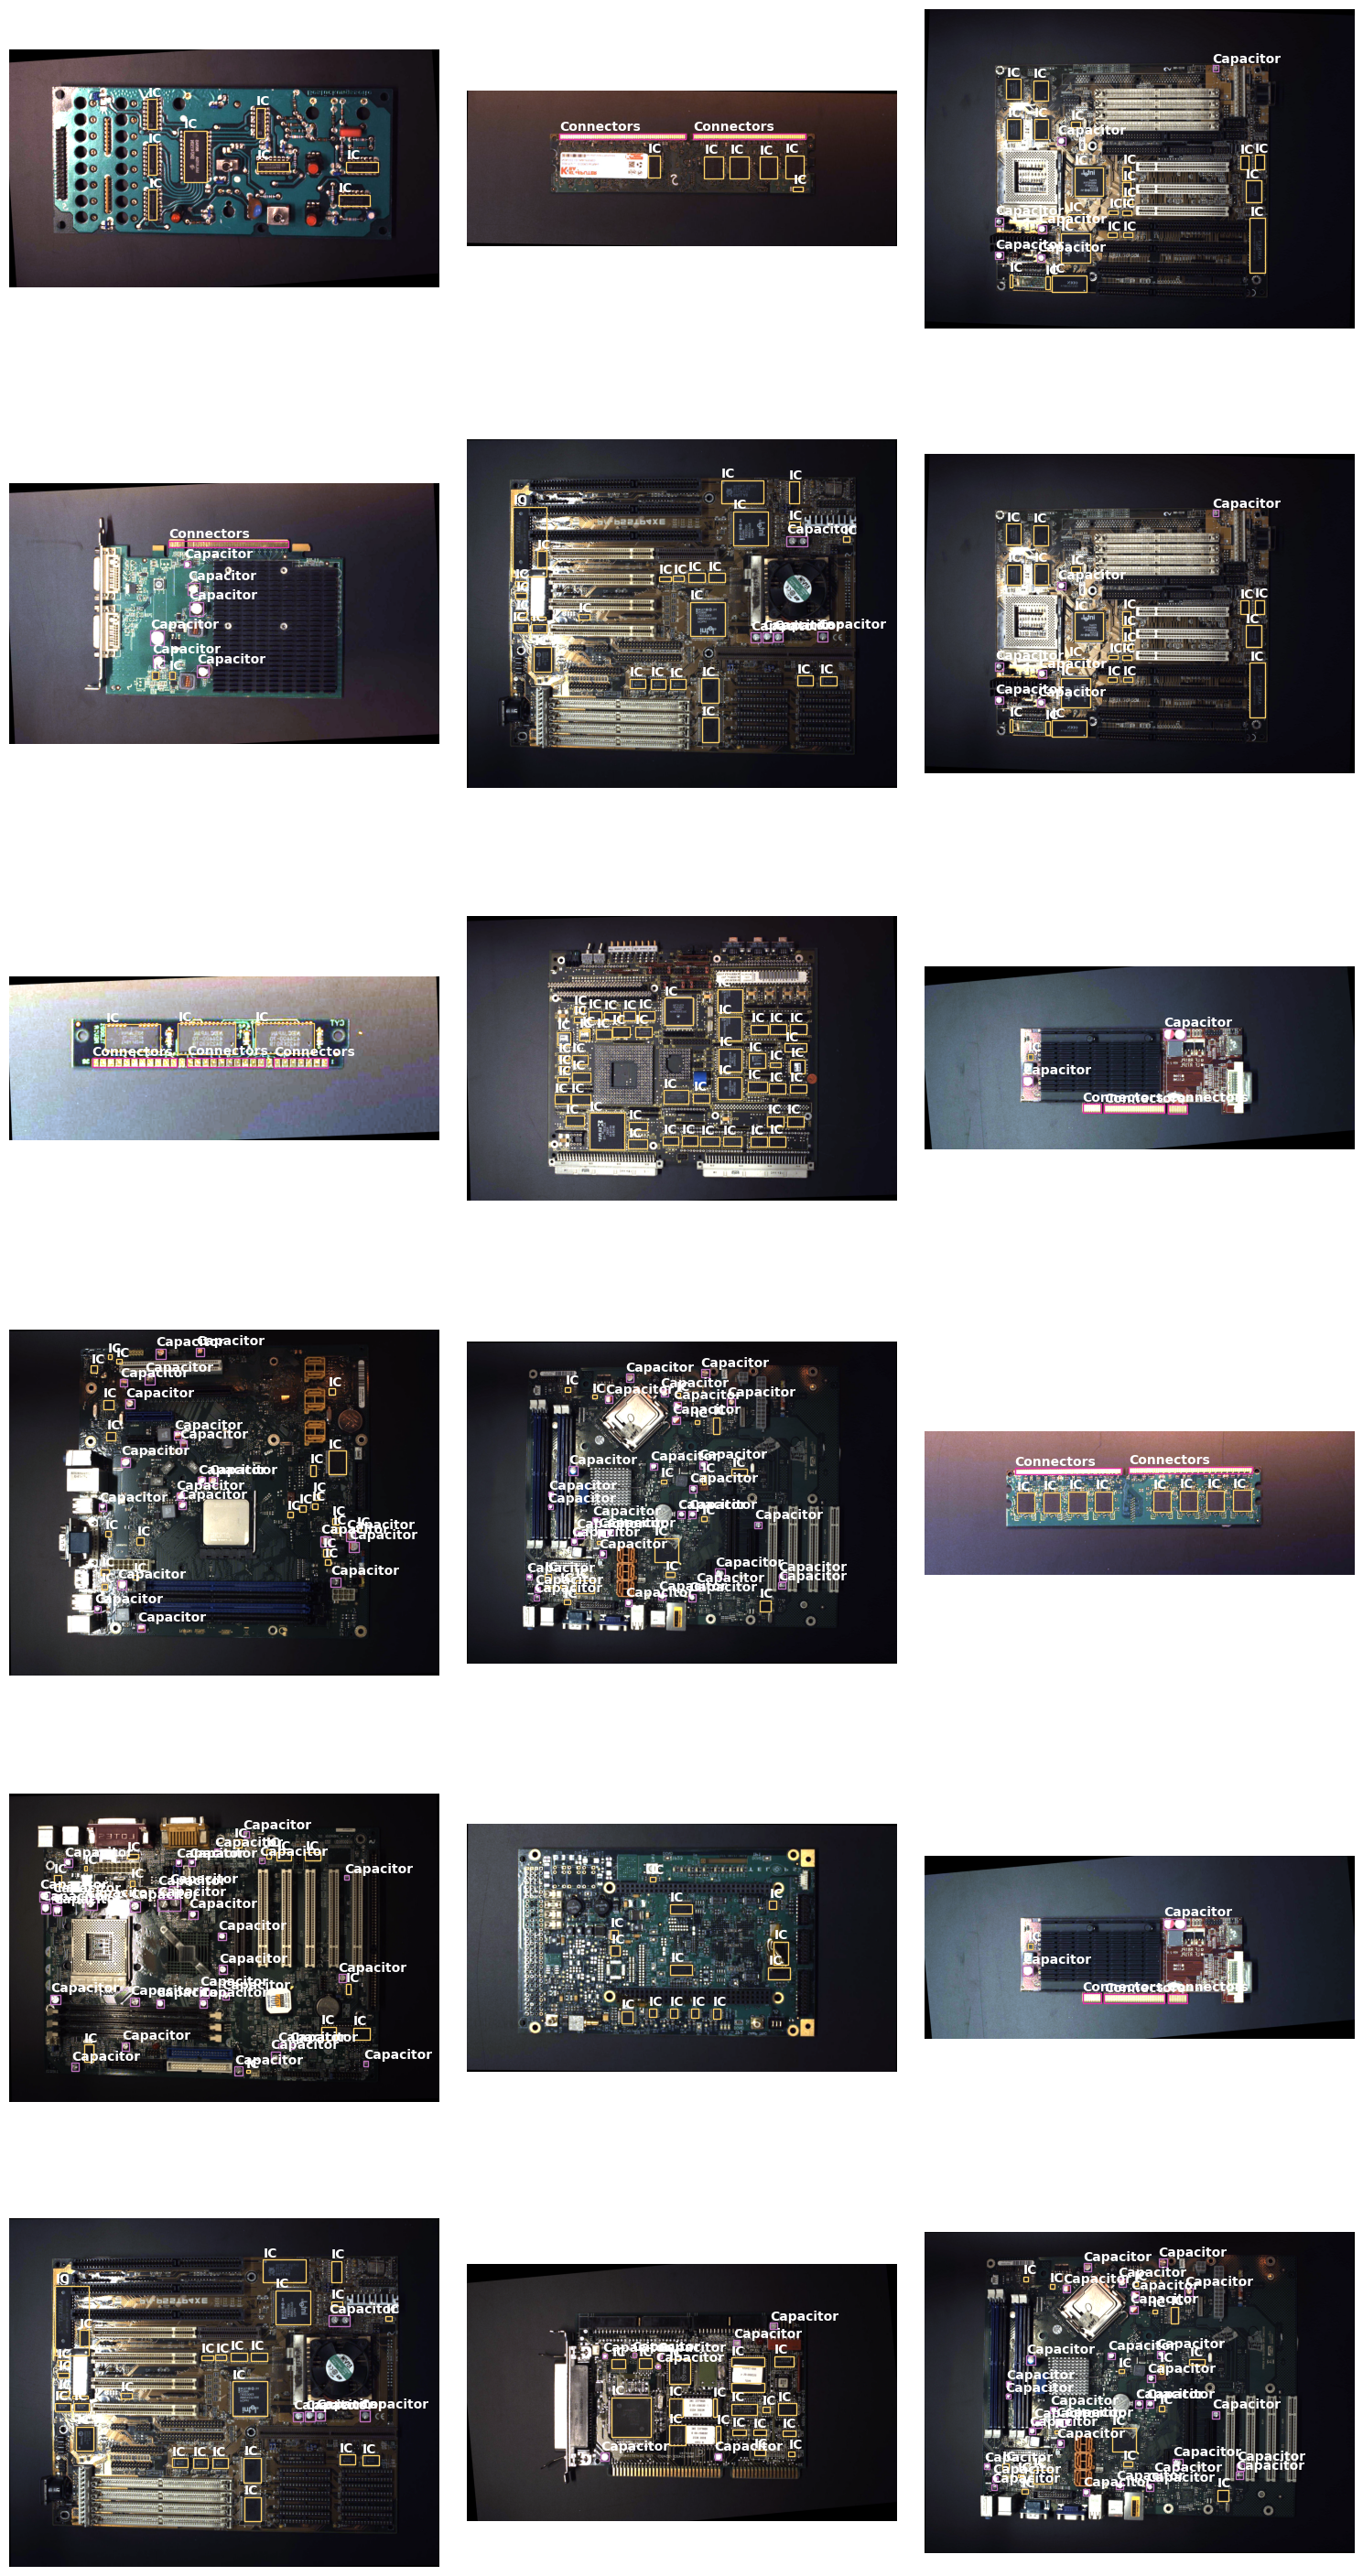

In [7]:
sample_yolo_dataset(PCB_VISION_YOLO_DIR / "train", CLASSES)